# Using Transformers on the 20 newsgroup dataset

In [1]:
from sklearn.datasets import fetch_20newsgroups
from transformers import AutoModel, AutoTokenizer

In [2]:
REMOVE = ('headers', 'footers', 'quotes')
news_train = fetch_20newsgroups(subset='train', remove=REMOVE)
news_test = fetch_20newsgroups(subset='test', remove=REMOVE)

The text in these datasets is complex in that it contains multiple paragraphs, where each paragraph can contain multiple sentences.

In [3]:
print(news_train.data[16])


I certainly do use it whenever I have to do TIFF, and it usually works
very well.  That's not my point.  I'm >philosophically< opposed to it
because of its complexity.

This complexity has led to some programs' poor TIFF writers making
some very bizarre files, other programs' inability to load TIFF
images (though they'll save them, of course), and a general
inability to interchange images between different environments
despite the fact they all think they understand TIFF.

As the saying goes, "It's not me I'm worried about- it's all the
abuse of TIFF over the years, and I chalk it all up to the immense (and
unnecessary) complexity of the format.

In the words of the TIFF 5.0 spec, Appendix G, page G-1 (capitalized
emphasis mine):

"The only problem with this sort of success is that TIFF was designed
to be powerful and flexible, at the expense of simplicity.  It takes a
fair amount of effort to handle all the options currently defined in
this specification (PROBABLY NO APPLICATION DOES

**TODO**, create a benchmark. 

What would be a reasonable benchmark? TfIdf + Naive Bayes?

We want to do two things:

1. Cluster these texts.
2. Build a classifier using BERT.

We start by extracting the texts and the classes from the data bunches.

In [4]:
train_txt, test_txt = news_train.data, news_test.data
train_cls, test_cls = news_train.target, news_test.target

## Without splitting by sentence

Below, we just consider the text in its entirety, and we don't care about the individual sentences.

In [5]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [6]:
def encode_strings(texts):
    dicts = []
    for txt in texts:
        dicts.append(
            tokenizer.encode_plus(txt, 
                                 add_special_tokens=True,
                                 max_length=128,
                                 pad_to_max_length=True,
                                 return_token_type_ids=False,
                                 return_attention_mask=True))
    return dicts

In [7]:
%%time
train_dicts = encode_strings(train_txt)

CPU times: user 1min 54s, sys: 79.7 ms, total: 1min 54s
Wall time: 1min 54s


In [8]:
train_input_ids = [d['input_ids'] for d in train_dicts]
train_attn_masks = [d['attention_mask'] for d in train_dicts]

In [9]:
%%time
test_dicts = encode_strings(test_txt)

CPU times: user 1min 1s, sys: 36 ms, total: 1min 1s
Wall time: 1min 1s


In [10]:
test_input_ids = [d['input_ids'] for d in test_dicts]
test_attn_masks = [d['attention_mask'] for d in test_dicts]

In [11]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_m, val_m, train_y, val_y = train_test_split(
    train_input_ids, 
    train_attn_masks, 
    train_cls, 
    test_size=0.2,
    shuffle=False)

In [12]:
import torch

train_x, train_m, train_y = (torch.tensor(train_x), torch.tensor(train_m), 
                             torch.tensor(train_y))
val_x, val_m, val_y = (torch.tensor(val_x), torch.tensor(val_m),
                       torch.tensor(val_y))

## Clustering

In [this example](https://huggingface.co/transformers/quickstart.html) they use also the segments IDs. **TODO** try them.

In [13]:
model = AutoModel.from_pretrained('bert-base-uncased')

In [14]:
model.eval()
inputs = train_x[0].unsqueeze(dim=0).to('cuda')
masks = train_m[0].unsqueeze(dim=0).to('cuda')
model.to('cuda')
with torch.no_grad():
    outputs = model(inputs, attention_mask=masks)

In [15]:
print(outputs[0].shape)
outputs[0][0]

torch.Size([1, 128, 768])


tensor([[-0.0668, -0.0782,  0.1245,  ..., -0.2077,  0.1575,  0.5708],
        [ 0.0073, -0.2461,  0.3578,  ...,  0.1776,  1.1425,  0.4231],
        [-0.3067,  0.3139,  0.2439,  ...,  0.5980, -0.2281,  0.4061],
        ...,
        [ 0.3048, -0.1508,  0.5161,  ...,  0.2338, -0.3044, -0.2507],
        [ 0.3263, -0.0415,  0.5331,  ...,  0.2175, -0.1918, -0.2351],
        [ 0.2452, -0.2577,  0.5242,  ...,  0.2065, -0.2932, -0.3365]],
       device='cuda:0')

The documentation (see the `outputs` section of the [BERT documentation](https://huggingface.co/transformers/model_doc/bert.html)) recommends to average the hidden states across the sequence length of each input.

In [16]:
outputs[0].mean(axis=1).shape

torch.Size([1, 768])

We cannot pass the whole dataset to the model, as it takes too much memory. We need a dataloader.

In [17]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

train_data = TensorDataset(train_x, train_m)
train_sampler = SequentialSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

In [18]:
model.eval()

results = []

for batch in train_loader:
    batch = tuple(t.to('cuda') for t in batch)
    x, m = batch
    with torch.no_grad():
        outputs = model(x, attention_mask=m)
        results.append(outputs[0].mean(axis=1).detach().cpu())

In [19]:
import numpy as np

tmp = np.concatenate(results, axis=0)

In [20]:
tmp.shape

(9051, 768)

## T-SNE

In [21]:
from sklearn.manifold import TSNE

z = TSNE(n_components=2).fit_transform(tmp)

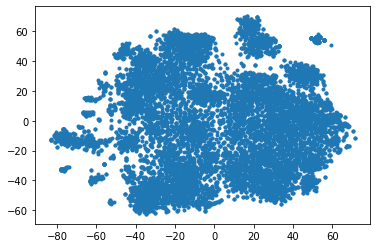

In [25]:
from matplotlib import pyplot as plt

plt.plot(z[:, 0], z[:, 1], '.')
plt.show()

In [38]:
np.savetxt('../data/embeddings.tsv', tmp, delimiter='\t')

In [81]:
import pandas as pd

txts = train_txt[slice(len(train_y))]
classes = train_cls[slice(len(train_y))]
assert(len(classes) == tmp.shape[0])

In [91]:
import re

stripped_texts = [re.sub('\s', '_', txt[:500]) for txt in txts]

In [96]:
annotations = pd.DataFrame({'text': stripped_texts, 'class': classes})

In [97]:
annotations.to_csv('../data/annotations.tsv', sep='\t')

In [94]:
tmp.shape, annotations.shape

((9051, 768), (9051, 2))

These two files can then be fed into the "embedding projector".

In [95]:
stripped_texts[:5]

['I_was_wondering_if_anyone_out_there_could_enlighten_me_on_this_car_I_saw_the_other_day._It_was_a_2-door_sports_car,_looked_to_be_from_the_late_60s/_early_70s._It_was_called_a_Bricklin._The_doors_were_really_small._In_addition,_the_front_bumper_was_separate_from_the_rest_of_the_body._This_is__all_I_know._If_anyone_can_tellme_a_model_name,_engine_specs,_years_of_production,_where_this_car_is_made,_history,_or_whatever_info_you_have_on_this_funky_looking_car,_please_e-mail.',
 'A_fair_number_of_brave_souls_who_upgraded_their_SI_clock_oscillator_have_shared_their_experiences_for_this_poll._Please_send_a_brief_message_detailing_your_experiences_with_the_procedure._Top_speed_attained,_CPU_rated_speed,_add_on_cards_and_adapters,_heat_sinks,_hour_of_usage_per_day,_floppy_disk_functionality_with_800_and_1.4_m_floppies_are_especially_requested.__I_will_be_summarizing_in_the_next_two_days,_so_please_add_to_the_network_knowledge_base_if_you_have_done_the_clock_upgrade_and_haven',
 'well_folks,_m

## Classification

We already have the dataset, we just need to modify our data loader and add an optimizer and a learning rate strategy.